# 9. 非线性滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

# 简介

我们所开发的卡尔曼滤波器使用线性方程，因此只能处理线性问题。但世界是非线性的，所以我们到目前为止学习的经典滤波器可能有非常有限的用处。

过程模型中可能存在非线性。假设我们想要跟踪一个物体在大气中下落的情况。物体的加速度取决于它所遇到的阻力。阻力取决于空气密度，而空气密度随着高度的增加而减小。在一维情况下，这可以用非线性微分方程来建模：

$$\ddot x = \frac{0.0034ge^{-x/22000}\dot x^2}{2\beta} - g$$

非线性的第二个来源来自于测量。例如，雷达测量物体的斜距，而我们通常关注的是飞机相对于地面的位置。我们运用毕达哥拉斯定理得到了非线性方程：

$$x=\sqrt{\mathtt{slant}^2 - \mathtt{altitude}^2}$$

这些事实并未被卡尔曼滤波器的早期采用者所忽视。卡尔曼博士发表论文后不久，人们就开始研究如何扩展卡尔曼滤波器以解决非线性问题。

几乎可以说，我们唯一熟知如何解的方程是 $\mathbf{Ax}=\mathbf{b}$。我们只真正了解如何进行线性代数。我可以给你任何线性方程组，你要么解决它，要么证明它没有解。

任何接受过数学或物理正规教育的人都花费了多年时间学习各种解积分、微分方程等的分析方法。然而，甚至是微不足道的物理系统也会产生无法解析求解的方程。我可以将你能够积分的方程加入 $\log$ 项，使其无法解决。这导致了物理学家们开玩笑地提出“假设在真空中有一个摩擦力为零的球形……”。在不进行极端简化的情况下，大多数物理问题都没有解析解。

那么，我们如何在计算机中模拟飞机上的气流，预测天气，或者使用卡尔曼滤波器追踪导弹？我们退而求其次，回归到我们所熟知的 $\mathbf{Ax}=\mathbf{b}$。我们找到某种方法将问题线性化，将其转化为一组线性方程，然后使用线性代数软件包计算一个近似解。

将非线性问题线性化会给我们带来不精确的答案，在像卡尔曼滤波器或天气跟踪系统这样的递归算法中，这些小错误有时会在每一步加强，迅速导致算法输出无意义的结果。

我们即将面临的是一个艰难的问题。不再有一个明显的、正确的、数学上最优的解决方案。我们将使用近似值，我们将在计算中引入错误，并且我们将永远与“发散”的滤波器进行斗争，即数值错误超过解的情况。

在本章的剩余部分，我将说明非线性卡尔曼滤波器面临的具体问题。只有在了解非线性问题在你的问题中引起的特定问题之后，你才能设计出一个滤波器。随后的章节将教你如何设计和实现不同类型的非线性滤波器。

# 带有非线性的问题

卡尔曼滤波器的数学之美部分源于高斯方程的特殊性。它是非线性的，但当我们将它们相加和相乘时，结果是另一个高斯分布。这是非常罕见的。$\sin{x}*\sin{y}$并不产生 $\sin$ 作为输出。

我所指的线性可能很明显，但其中有些微妙之处。数学要求有两个方面：

* 可加性：$f(x+y) = f(x) + f(y)$
* 齐次性：$f(ax) = af(x)$

这导致我们说线性系统被定义为其输出与所有输入之和成比例的系统。这意味着如果输入为零，那么输出也必须为零。考虑一个音频放大器 - 如果我对着麦克风唱歌，你开始说话，输出应该是我们声音（输入）乘以放大器增益的总和。但如果放大器输出一个非零信号，比如一个嗡嗡声，对于零输入，加法关系不再成立。这是因为线性要求 $amp(voice) = amp(voice + 0)$。这显然应该给出相同的输出，但如果 amp(0) 是非零的，那么

$$
\begin{aligned}
amp(voice) &= amp(voice + 0) \\
&= amp(voice) + amp(0) \\
&= amp(voice) + non\_zero\_value
\end{aligned}
$$

这显然是荒谬的。因此，一个表面上是线性方程的式子，比如

$$L(f(t)) = f(t) + 1$$

并不是线性的，因为 $L(0) = 1$。要小心啊！

# 问题的直观视角

我特别喜欢以下这种看待问题的方式，这个观点来自丹·西蒙的《最优状态估计》。想象一个追踪问题，我们获得了到目标的距离和方位角，希望跟踪其位置。报告的距离是50公里，报告的角度是90°。假设距离和角度的误差都服从高斯分布。在进行无限次测量的情况下，位置的期望值是多少？

我一直推荐使用直觉来获取洞察力，所以让我们看看它对这个问题的表现如何。我们可能会推理认为，由于距离的平均值将是50公里，角度的平均值将是90°，答案将是 x=0公里，y=50公里。

让我们绘制出来看看。这里有3000个点，距离服从0.4公里的正态分布，角度服从0.35弧度的正态分布。我们计算所有位置的平均值，并将其显示为星号。我们的直觉则以一个大圆表示。

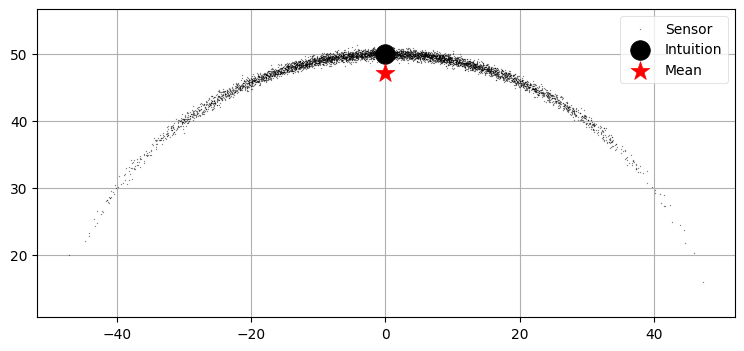

In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

N = 5000
a = np.pi/2. + (randn(N) * 0.35)
r = 50.0     + (randn(N) * 0.4)
xs = r * np.cos(a)
ys = r * np.sin(a)

plt.scatter(xs, ys, label='Sensor', color='k', 
            alpha=0.4, marker='.', s=1)
xmean, ymean = sum(xs) / N, sum(ys) / N
plt.scatter(0, 50, c='k', marker='o', s=200, label='Intuition')
plt.scatter(xmean, ymean, c='r', marker='*', s=200, label='Mean')
plt.axis('equal')
plt.legend();

我们可以看到，我们的直觉失败了，因为问题的非线性性导致所有误差都偏向一个方向。这种偏差在许多迭代中会导致卡尔曼滤波器发散。即使它没有发散，解也不会是最优的。对非线性问题应用线性近似会产生不准确的结果。

# 非线性函数对高斯分布的影响

高斯分布在任意非线性函数下不是封闭的。回想一下卡尔曼滤波器的方程 - 在每次演化中，我们通过过程函数传递表示状态的高斯分布，以获得时刻$k$的高斯分布。我们的过程函数总是线性的，因此输出始终是另一个高斯分布。让我们在图表上看看这个过程。我会取一个任意的高斯分布，经过函数$f(x) = 2x + 1$，然后绘制结果。我们知道如何用解析法做这件事，但让我们使用抽样方法。我将生成50万个服从正态分布的点，经过$f(x)$处理，然后绘制结果。我这样做是因为接下来的例子将是非线性的，我们将无法用解析法来计算这个结果。

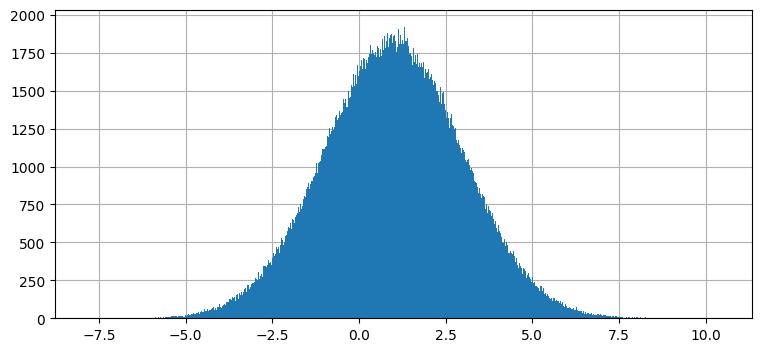

In [4]:
from numpy.random import normal

data = normal(loc=0., scale=1., size=500000)
plt.hist(2*data + 1, 1000);

这个结果并不令人意外。将高斯分布通过 $f(x)=2x+1$ 处理的结果是另一个以1为中心的高斯分布。让我们同时看一下输入、非线性函数和输出。

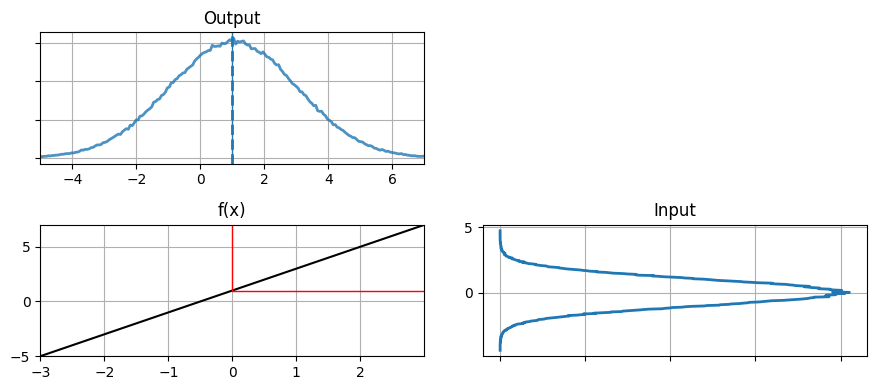

In [6]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_nonlinear_func

def g1(x):
    return 2*x+1

plot_nonlinear_func(data, g1)

>在支持笔记本文件夹的 *Computing_and_Plotting_PDFs* 中，我解释了如何绘制高斯分布，以及更多内容。你也可以在线阅读 [这里](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb)。

图表中标记为“输入”的是原始数据的直方图。这些数据经过函数 $f(x)=2x+1$ 处理，显示在左下角的图表中。红线展示了如何将一个值 $x=0$ 通过这个函数处理。输入中的每个值都通过同样的方式传递到右侧的输出函数。对于输出，我通过取所有点的平均值来计算均值，并用虚线蓝线绘制结果。实线蓝线显示了点 $x=0$ 的实际均值。输出看起来像一个高斯分布，事实上也确实是一个高斯分布。我们可以看到输出的方差大于输入的方差，并且均值已经从0移动到1，这符合我们根据转移函数 $f(x)=2x+1$ 的预期。$2x$ 影响了方差，而$+1$ 移动了均值。虚线蓝线表示的计算均值几乎等于实际均值。如果我们在计算中使用更多点，我们可以无限接近实际值。

现在让我们来看一个非线性函数，并看看它如何影响概率分布。

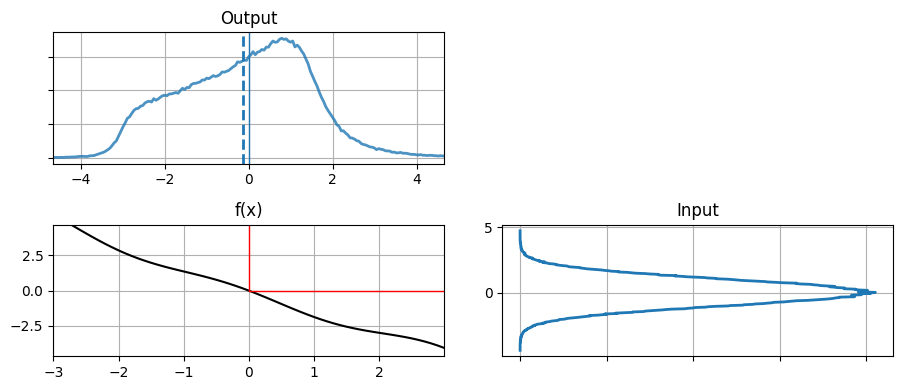

In [8]:
def g2(x):
    return (np.cos(3*(x/2 + 0.7))) * np.sin(0.3*x) - 1.6*x

plot_nonlinear_func(data, g2)

这个结果可能对你来说有些意外。这个函数看起来“相当”线性，但输出的概率分布与高斯分布完全不同。回顾一下两个单变量高斯分布相乘的方程：

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2} \\
\sigma &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

这些方程不适用于非高斯分布，当然也不适用于上面“输出”图表中显示的概率分布。

以下是另一种观察相同数据的方法，使用散点图。

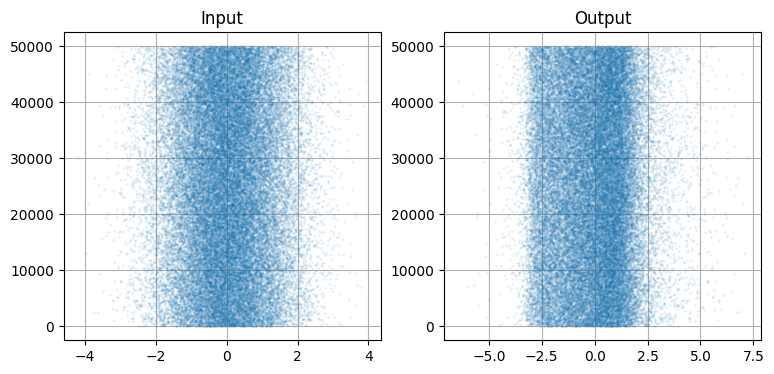

In [12]:
N = 50000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.1, s=1.5)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(g2(data[:N]), range(N), alpha=.1, s=1.5);

原始数据显然是高斯分布的，但经过 `g2(x)` 处理的数据不再呈正态分布。在-3附近有一个厚厚的带状区域，并且这个区域的两侧点的分布不均匀。如果你将这个与前一个图表中标记为“输出”的概率密度函数进行比较，你应该能够看到概率密度函数的形状如何与 `g(data)` 的分布相匹配。

思考一下这对于前一章的卡尔曼滤波器算法意味着什么。所有的方程都假设通过过程函数的高斯分布会得到另一个高斯分布。如果这不成立，那么卡尔曼滤波器的所有假设和保证都不成立。让我们看看当我们再次将输出通过函数传递时会发生什么，模拟卡尔曼滤波器的下一个时间步。

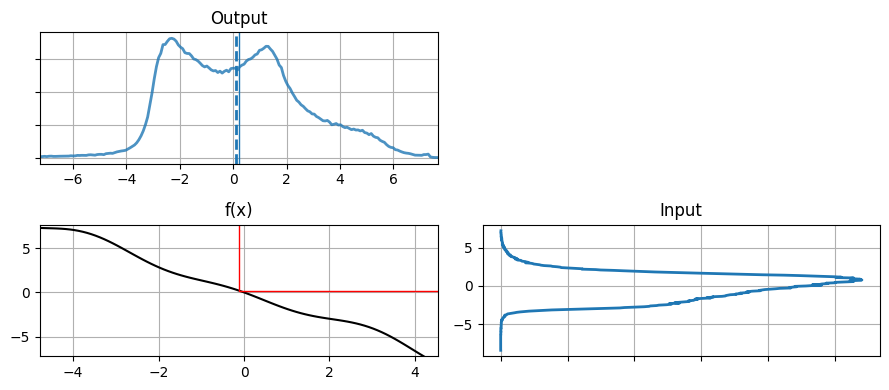

In [10]:
y = g2(data)
plot_nonlinear_func(y, g2)

正如你所看到的，概率函数进一步扭曲，不再呈现原始的高斯分布特征。然而，图表在x=0附近仍然有一定的对称性，让我们看看平均值是多少。

In [13]:
print('input  mean, variance: %.4f, %.4f' % 
      (np.mean(data), np.var(data)))
print('output mean, variance: %.4f, %.4f' % 
      (np.mean(y), np.var(y)))

input  mean, variance: -0.0016, 1.0009
output mean, variance: -0.1224, 2.4058


让我们将其与通过(-2,3)和(2,-3)两点的线性函数进行比较，这个线性函数非常接近我们绘制的非线性函数。使用直线的方程我们有：

$$m=\frac{-3-3}{2-(-2)}=-1.5$$

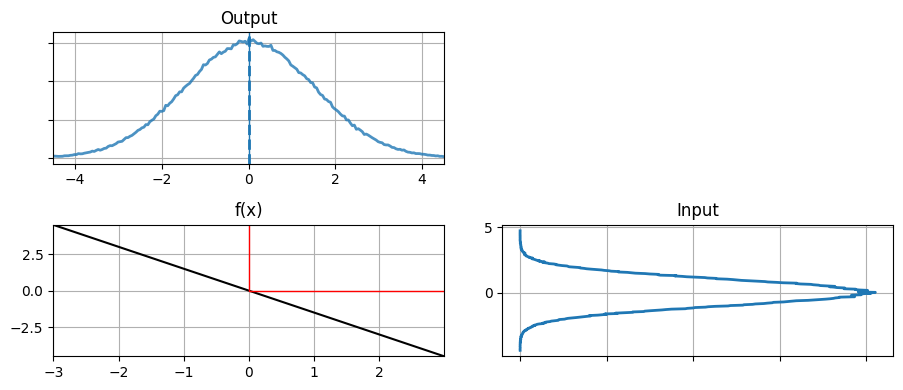

output mean, variance: 0.0024, 2.2520


In [14]:
def g3(x): 
    return -1.5 * x

plot_nonlinear_func(data, g3)
out = g3(data)
print('output mean, variance: %.4f, %.4f' % 
      (np.mean(out), np.var(out)))

尽管输出的形状非常不同，但每个输出的均值和方差几乎相同。这可能会让我们推断，也许如果非线性方程“接近于”线性，我们可以忽略这个问题。为了测试这一点，我们可以进行多次迭代，然后比较结果。

In [15]:
out = g3(data)
out2 = g2(data)

for i in range(10):
    out = g3(out)
    out2 = g2(out2)
print('linear    output mean, variance: %.4f, %.4f' % 
      (np.average(out), np.std(out)**2))
print('nonlinear output mean, variance: %.4f, %.4f' % 
      (np.average(out2), np.std(out2)**2))

linear    output mean, variance: 0.1386, 7488.4185
nonlinear output mean, variance: -8.9071, 30512.8739


遗憾的是，非线性版本并不稳定。它与均值0相差很远，方差大约高了半个数量级。

我通过使用一个非常接近直线的函数来尽量减小了问题。如果函数是 $y(x)=-x^2$ 会发生什么呢？

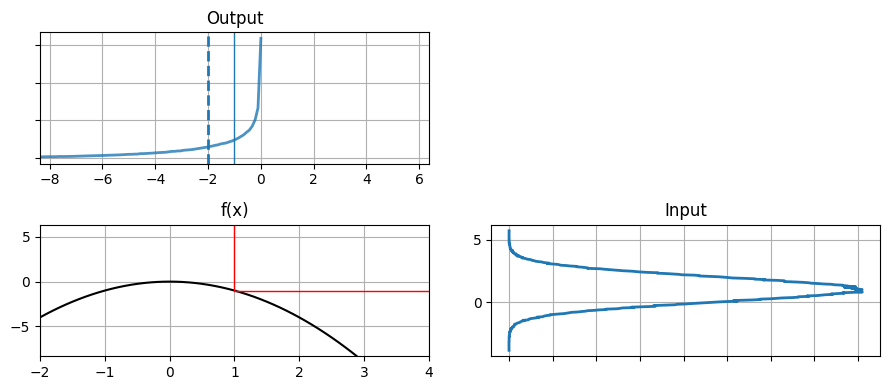

In [16]:
def g3(x): 
    return -x*x

data = normal(loc=1, scale=1, size=500000)
plot_nonlinear_func(data, g3)

尽管在 $x=1$ 处曲线平滑且相当直，但输出的概率分布看起来与高斯分布完全不同，并且计算得到的输出均值与输入均值相当不同。这不是一个不寻常的函数 - 一个弹道物体运动在抛物线上，这就是你的滤波器需要处理的非线性。如果你记得我们曾试图追踪一个球但失败了。这个图表应该让你明白为什么滤波器表现得如此糟糕。

# 一个2D的例子

很难通过概率分布来推断滤波器会发生什么。所以让我们考虑用雷达跟踪飞机的情况。估计值可能具有这样的协方差：

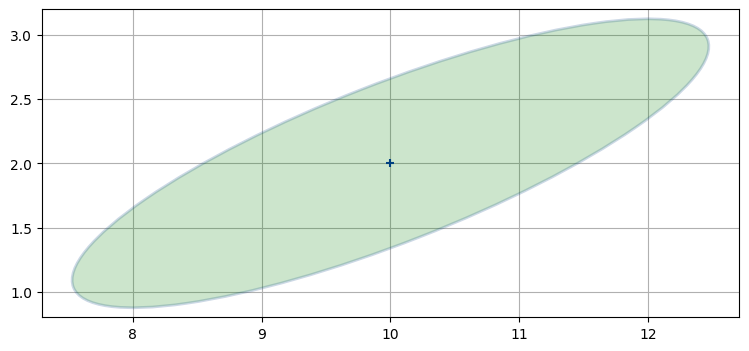

In [17]:
import kf_book.nonlinear_internal as nonlinear_internal

nonlinear_internal.plot1()

当我们尝试线性化这个问题时会发生什么呢？雷达给出了飞机的距离。假设雷达位于飞机正下方（x=10），下一次测量显示飞机距离3英里（y=3）。能够与该测量匹配的位置形成一个半径为3英里的圆，如下图所示。

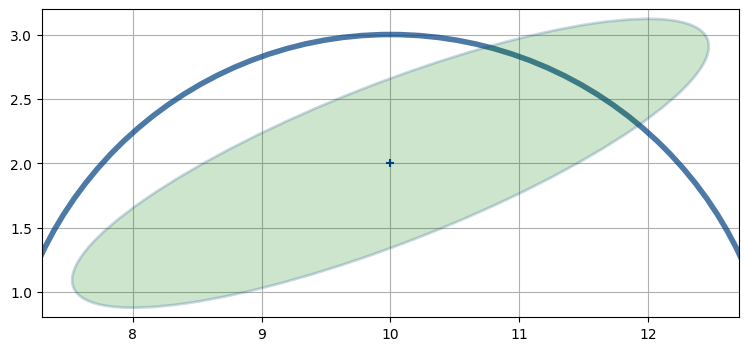

In [18]:
nonlinear_internal.plot2()

我们可以通过观察得知，飞机可能的位置在 x=11.4，y=2.7 附近，因为那是协方差椭圆和距离测量重叠的地方。但是，距离测量是非线性的，所以我们必须对其进行线性化。我们还没有涉及这部分内容，但扩展卡尔曼滤波器会在飞机的最后位置（10,2）处进行线性化。在 x=10 处，距离测量为 y=3，因此我们会在该点进行线性化处理。

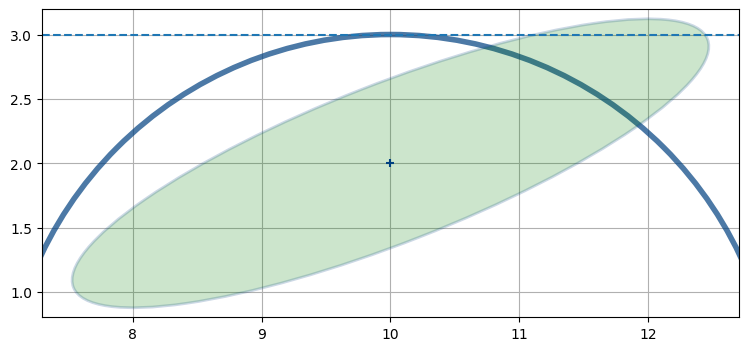

In [19]:
nonlinear_internal.plot3()

现在我们有了问题的线性表示（确切地说是一条直线），我们可以解决它。不幸的是，你可以看到线与协方差椭圆的交点离实际飞机位置很远。

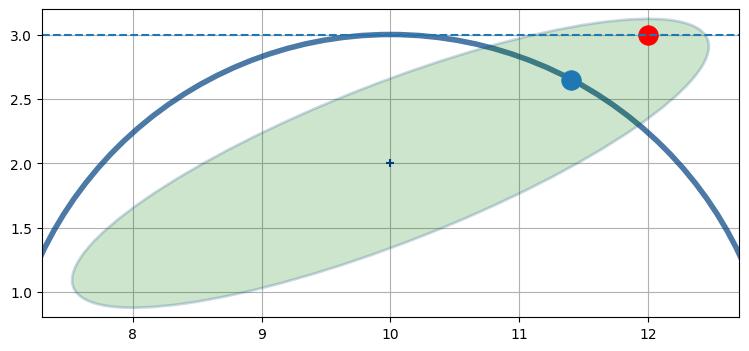

In [20]:
nonlinear_internal.plot4()

这种类型的错误常常会导致灾难性的结果。这个估计的误差很大。而在滤波器的下一个创新中，这个非常糟糕的估计将被用来线性化下一个雷达测量，因此下一个估计很可能比这个要糟糕得多。经过几次迭代后，卡尔曼滤波器将发散，并开始产生与现实毫不相关的结果。

这个协方差椭圆跨度很大。我夸大了它的大小以说明高度非线性系统的困难。在真实的雷达跟踪问题中，非线性通常不会那么糟糕，但误差仍然会累积。你可能会在其他系统中遇到同样程度的非线性 - 这并不是为了强调而夸大的。在处理非线性系统时，你总是会不断地与发散作斗争。

# 算法

你可能急于解决特定问题，想知道应该使用哪种滤波器。我将快速概述一下选项。后续章节有一定独立性，你可以跳跃阅读，但如果你真的想掌握所有的内容，我建议你按顺序阅读。

非线性滤波器的主要内容是 *线性化卡尔曼滤波器* 和 *扩展卡尔曼滤波器*（EKF）。这两种技术是在卡尔曼发表论文后不久发明的，并且自那时以来一直是主要使用的技术。飞机的飞行软件，你车或手机上的GPS几乎肯定使用了其中一种技术。

然而，这些技术要求非常高。EKF在一个点线性化微分方程，这要求你求解一个偏导数矩阵（雅可比矩阵）。这在解析上可能很困难或不可能完成。如果不可能，你必须使用数值技术来求解雅可比矩阵，但这在计算上是昂贵的，并且会引入更多的误差到系统中。最后，如果问题非常非线性，线性化会导致每一步引入大量误差，滤波器经常会发散。你不能将一些方程随意投入某个求解器中然后期望得到良好的结果。对于专业人士来说，这是一个困难的领域。我注意到，尽管EKF是实际应用中最常用的技术，但大多数卡尔曼滤波教材对EKF只是简单地介绍了一下。

最近，这个领域正在以激动人心的方式发生变化。首先，计算能力已经发展到可以使用超级计算机难以实现的技术水平。这些使用 *蒙特卡洛* 技术 - 计算机生成数千甚至数万个随机点，并测试它们与测量的匹配程度。然后，基于它们与测量的匹配程度，以概率方式淘汰或复制点。远离测量的点不太可能被保留，而非常接近的点则很可能被保留。经过几次迭代后，就会有一簇粒子紧密地跟踪着你的对象，以及一个稀疏的点云，在那里没有对象。

这有两个好处。首先，即使对于非常非线性的问题，该算法也具有鲁棒性。其次，该算法可以同时跟踪任意多个对象 - 一些粒子会匹配一个对象的行为，而其他粒子会匹配其他对象。因此，这种技术通常用于跟踪汽车交通、人群等。

代价是明显的。对于滤波器中的每一步测试数万个点在计算上很昂贵。但是现代CPU运算速度非常快，这对GPU来说是一个很好的问题，因为算法的一部分可以并行化。另一个代价是答案不是数学的。用卡尔曼滤波器，协方差矩阵为我们提供了估计误差的重要信息。而粒子滤波器并没有给出一个严格计算这个的方式。最后，滤波器的输出是一堆点；然后你必须想办法去解释它。通常你会做的事情类似于计算点的平均值和标准偏差，但这是一个困难的问题。仍然有很多点并不属于被跟踪的对象，所以你首先必须运行某种聚类算法来找到似乎在跟踪一个对象的点，然后你需要另一个算法来从这些点中产生一个状态估计。这一切都不是不可行的，但都是非常计算密集的。

最后，我们有一个新算法，被称为 *无迹卡尔曼滤波器*（UKF）。它不要求你找到非线性方程的解析解，但几乎总是比EKF表现更好。它在非线性问题上表现良好 - 这些是EKF遇到困难的问题。设计滤波器非常容易。有些人会说对于UKF，裁决仍然没有下定论，但在我看来，UKF在几乎每个方面都优于EKF。我建议UKF应该是任何实现的起点，特别是如果你不是控制理论研究的卡尔曼滤波专家。主要的缺点是UKF可能比EKF慢几倍，但这取决于EKF是用解析方式还是数值方式求解雅可比矩阵。如果是数值方式，UKF几乎肯定更快。尚未证明（也可能无法证明）UKF总是产生比EKF更准确的结果。在实践中，它几乎总是如此，而且通常差距显著。它非常容易理解和实现，我强烈建议作为你的起点使用这个滤波器。

# 总结

世界是非线性的，但我们只真正了解如何解决线性问题。这给卡尔曼滤波器带来了很大的困难。我们已经以三种不同但等效的方式看了非线性如何影响滤波，我还给了你对主要方法的简要总结：线性化卡尔曼滤波器，扩展卡尔曼滤波器，无迹卡尔曼滤波器和粒子滤波器。

直到最近，线性化卡尔曼滤波器和EKF一直是解决这些问题的标准方法。它们非常难理解和使用，而且也可能非常不稳定。

最近的发展提供了在我看来更优越的方法。UKF不需要找到偏微分方程的解，但通常比EKF更准确。它易于使用和理解。我可以在几分钟内使用FilterPy快速创建一个基本的UKF。粒子滤波器完全放弃了数学建模，采用了一个生成数千个随机点的蒙特卡洛技术的方法。它运行速度较慢，但可以相对容易地解决其他难以处理的问题。

我收到的邮件中关于EKF的问题比其他任何问题都多；我猜这是因为大多数教材、论文和互联网上的资料都使用EKF。当然，如果你想精通这个领域，你肯定会想了解EKF。但如果你只是想得到好的结果，我会首先推荐你尝试UKF和粒子滤波器。它们更容易实现、理解和使用，并且通常比EKF更加稳定。

有些人可能对这个建议有异议。最近的很多出版物都致力于比较EKF、UKF以及其他一些选择对于特定问题的应用。你的问题也不需要进行类似的比较吗？如果你要发射火箭到火星，那当然需要。你将需要平衡精度、四舍五入误差、发散、数学正确性的证明以及所需的计算工作量等问题。我无法想象不熟悉EKF的情况。

另一方面，UKF的表现非常好！我在工作中用于实际应用。对于这些应用，我大部分时间甚至都没有尝试过使用EKF，因为我可以验证UKF的工作良好。在某些情况下，我是否可能从EKF中获得另外0.2%的性能？可能！我在乎吗？不！我完全了解UKF的实现，它易于测试和验证，我可以把代码传递给其他人，并且确信他们能够理解和修改它。我不是一个喜欢在已有解决方案的情况下与困难的方程作斗争的 masochist。如果UKF或粒子滤波器在某些问题上表现不佳，那么我将转向其他技术，但在此之前不会。而现实情况是，UKF通常在很多问题和条件下提供比EKF更为出色的性能。如果“相当好”已经足够了，我会花时间解决其他问题。

我强调这一点是因为在大多数教科书中，EKF占据主导地位，而UKF要么根本没有提到，要么只是简单地给了两页介绍，让你完全无法准备好使用该滤波器。UKF仍然相对较新，而且编写新版本的书籍需要时间。在许多书籍被编写的时候，UKF要么尚未被发现，要么只是一个未经验证但很有前景的奇特方法。但就我现在所写的内容而言，UKF取得了巨大的成功，并且它应该成为你的工具箱中的一部分。这是我将努力教给你的大部分内容。

# 参考

<A name="[1]">[1]</A> https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb